<a href="https://colab.research.google.com/github/Chaotic-Legend/CMP-414-Codes/blob/main/Homework%20%234%3A%20Pretrained%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #4: Pretrained Networks
#### CMP 414: Artificial Intelligence - Isaac D. Hoyos

1. Find an image of a donkey from the internet and download the image to the Colab environment.

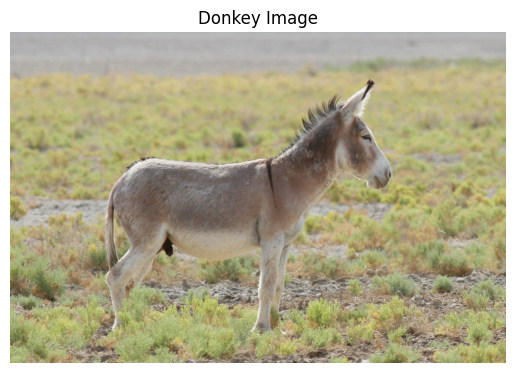

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

url = "https://inaturalist-open-data.s3.amazonaws.com/photos/140505310/original.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

img.save("/content/donkey.jpg")

plt.imshow(img)
plt.axis("off")
plt.title("Donkey Image")
plt.show()

2. Use pretrained ResNet101 to predict the label. Display the top-5 labels of this image predicted by this model.

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from tabulate import tabulate

resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
resnet.eval()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img).unsqueeze(0)
with torch.no_grad():
    output = resnet(input_tensor)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
categories = models.ResNet101_Weights.IMAGENET1K_V1.meta["categories"]
results = [(i+1, categories[top5_catid[i]], f"{top5_prob[i]*100:.2f}%") for i in range(5)]
print("=== Top 5 Predictions (ResNet101) ===")
print(tabulate(results, headers=["Rank", "Label", "Confidence"], tablefmt="fancy_grid"))

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:01<00:00, 132MB/s]


=== Top 5 Predictions (ResNet101) ===
╒════════╤═════════════╤══════════════╕
│   Rank │ Label       │ Confidence   │
╞════════╪═════════════╪══════════════╡
│      1 │ hartebeest  │ 33.14%       │
├────────┼─────────────┼──────────────┤
│      2 │ gazelle     │ 11.03%       │
├────────┼─────────────┼──────────────┤
│      3 │ timber wolf │ 9.24%        │
├────────┼─────────────┼──────────────┤
│      4 │ coyote      │ 8.52%        │
├────────┼─────────────┼──────────────┤
│      5 │ ibex        │ 5.38%        │
╘════════╧═════════════╧══════════════╛


3. Use the pretrained CycleGAN model to transform the image. Display the transformed image. Was CycleGAN able to convert the donkey to a zebra? Why?


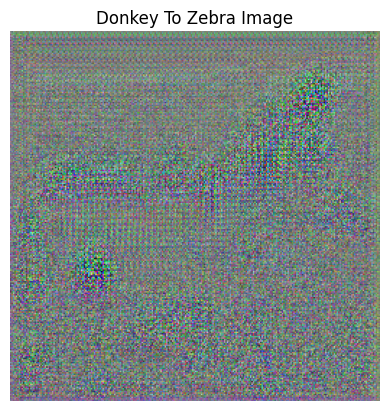

In [ ]:
!wget -q https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/master/data/p1ch2/horse2zebra_0.4.0.pth

import torch, os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.InstanceNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(3, 64, 7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
            *[ResidualBlock(256) for _ in range(6)],
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 3, 7, padding=3),
            nn.Tanh()
        ]
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)

model_path = "horse2zebra_0.4.0.pth"
netG = Generator().to(device)
netG.load_state_dict(torch.load(model_path, map_location=device), strict=False)
netG.eval()

img_path = "/content/donkey.jpg"
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Error: Image Not Found: {img_path}")

img = Image.open(img_path).convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
input_tensor = preprocess(img).unsqueeze(0).to(device)

with torch.no_grad():
    output_tensor = netG(input_tensor)
output_tensor = (output_tensor.squeeze(0).cpu() * 0.5 + 0.5).clamp(0, 1)
to_pil = transforms.ToPILImage()
output_image = to_pil(output_tensor)
output_image.save("/content/donkey_to_zebra.jpg")

plt.imshow(output_image)
plt.axis("off")
plt.title("Donkey To Zebra Image")
plt.show()

The pretrained CycleGAN model was used to transform an image of a donkey into a zebra. However, the results were not accurate because the model was trained exclusively on horse–zebra image pairs. Although donkeys share some visual traits with horses, their distinct textures and shapes fall outside the model's learned domain. Consequently, CycleGAN only partially altered the donkey's appearance, producing faint or misplaced zebra-like patterns rather than a realistic zebra transformation.

4. Build the pretrained AlexNet model from PyTorch Hub. Display the top-5 labels of this image predicted by this model.

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from tabulate import tabulate

alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
alexnet.eval()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(img).unsqueeze(0)
with torch.no_grad():
    output = alexnet(input_tensor)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
categories = models.AlexNet_Weights.IMAGENET1K_V1.meta["categories"]
results = [(i+1, categories[top5_catid[i]], f"{top5_prob[i]*100:.2f}%") for i in range(5)]
print("=== Top 5 Predictions (AlexNet) ===")
print(tabulate(results, headers=["Rank", "Label", "Confidence"], tablefmt="fancy_grid"))

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 131MB/s]


=== Top 5 Predictions (AlexNet) ===
╒════════╤════════════╤══════════════╕
│   Rank │ Label      │ Confidence   │
╞════════╪════════════╪══════════════╡
│      1 │ coyote     │ 54.04%       │
├────────┼────────────┼──────────────┤
│      2 │ hartebeest │ 12.91%       │
├────────┼────────────┼──────────────┤
│      3 │ gazelle    │ 9.64%        │
├────────┼────────────┼──────────────┤
│      4 │ dingo      │ 7.01%        │
├────────┼────────────┼──────────────┤
│      5 │ impala     │ 3.20%        │
╘════════╧════════════╧══════════════╛


5. Find an image with multiple objects in it. Test the YOLO object detection model with this image. Display the locations and labels of the objects detected.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/multi_objects.jpg: 448x640 1 keyboard, 1 cell phone, 1 scissors, 3 teddy bears, 205.8ms
Speed: 12.3ms preprocess, 205.8ms inference, 20.7ms postprocess per image at shape (1, 3, 448, 640)


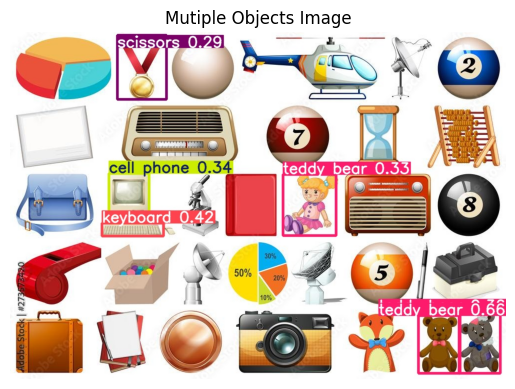

=== Detected Objects (YOLOv8) ===
╒═════╤════════════╤══════════════╤══════════════════════╕
│   # │ Label      │ Confidence   │ Bounding Box         │
╞═════╪════════════╪══════════════╪══════════════════════╡
│   1 │ teddy bear │ 65.65%       │ (823, 572, 907, 689) │
├─────┼────────────┼──────────────┼──────────────────────┤
│   2 │ keyboard   │ 42.08%       │ (185, 387, 310, 412) │
├─────┼────────────┼──────────────┼──────────────────────┤
│   3 │ teddy bear │ 35.52%       │ (906, 565, 988, 689) │
├─────┼────────────┼──────────────┼──────────────────────┤
│   4 │ cell phone │ 33.88%       │ (199, 287, 281, 387) │
├─────┼────────────┼──────────────┼──────────────────────┤
│   5 │ teddy bear │ 33.31%       │ (551, 288, 657, 411) │
├─────┼────────────┼──────────────┼──────────────────────┤
│   6 │ scissors   │ 29.25%       │ (217, 9, 315, 137)   │
╘═════╧════════════╧══════════════╧══════════════════════╛


In [ ]:
!pip install ultralytics > /dev/null
from ultralytics import YOLO
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tabulate import tabulate

url2 = "https://as1.ftcdn.net/jpg/02/73/57/34/1000_F_273573420_z9OGutxdQOaFfGbDLq7PadLkA04bsFeh.jpg"
response2 = requests.get(url2)
multi_img = Image.open(BytesIO(response2.content)).convert("RGB")
multi_img.save("multi_objects.jpg")
model = YOLO('yolov8n.pt')

results = model("multi_objects.jpg", show=True)
results[0].save(filename="detected_objects.jpg")
plt.imshow(Image.open("detected_objects.jpg"))
plt.axis('off')
plt.title("Mutiple Objects Image")
plt.show()

table_data = []
for i, box in enumerate(results[0].boxes):
    label = results[0].names[int(box.cls)]
    confidence = float(box.conf)
    x1, y1, x2, y2 = map(float, box.xyxy[0])
    table_data.append([
        i + 1,
        label,
        f"{confidence*100:.2f}%",
        f"({x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f})"
    ])

print("=== Detected Objects (YOLOv8) ===")
print(tabulate(table_data, headers=["#","Label","Confidence","Bounding Box"], tablefmt="fancy_grid"))